In [2]:
import os
import random
import torch
import requests
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

The console stream is logged into /root/sg_logs/console.log


[2023-09-07 14:19:55] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-09-07 14:19:56] WARNING - __init__.py - Failed to import pytorch_quantization
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2023-09-07 14:20:07] INFO - utils.py - NumExpr defaulting to 2 threads.
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-07 14:20:12] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-07 14:20:12] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-07 14:20:12] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantizatio

In [3]:
class config:
    
    CHECKPOINT_DIR = 'checkpoints' 
    EXPERIMENT_NAME = 'finding-battleships' 
    
    #dataset parameters
    DATA_DIR = '/home/iiserb/Downloads/road-object-detection' 
    TRAIN_IMAGES_DIR = 'train/images' 
    TRAIN_LABELS_DIR = 'train/labels' 
    VAL_IMAGES_DIR = 'valid/images' 
    VAL_LABELS_DIR = 'valid/labels' 
    TEST_IMAGES_DIR = 'test/images' 
    TEST_LABELS_DIR = 'test/labels' 

    CLASSES = ['bicycle', 'bus', 'car', 'motorbike', 'person']

    NUM_CLASSES = len(CLASSES)


    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model parameters
    MODEL_NAME = 'yolo_nas_l' 
    PRETRAINED_WEIGHTS = 'coco'

In [4]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, 
                  ckpt_root_dir=config.CHECKPOINT_DIR)

In [5]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-09-07 14:20:14] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 5805/5805 [01:42<00:00, 56.42it/s]
[2023-09-07 14:21:57] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 549/549 [00:06<00:00, 81.16it/s]
[2023-09-07 14:22:05] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:  95%|█████████▍| 265/279 [00:03<00:00, 89.55it/s]

# See train data

In [6]:
train_data.dataset.plot()

# Model

In [7]:
model = models.get(config.MODEL_NAME, 
                   num_classes=config.NUM_CLASSES, 
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2023-09-07 14:22:13] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:09<00:00, 29.6MB/s]
[2023-09-07 14:22:23] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [8]:
train_params = {
    
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    
    #TRAINING FOR 10 EPOCHS 
    "max_epochs": 10,
    "mixed_precision": True, 
    "loss": PPYoloELoss(
        use_static_assigner=False,
      
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# Train the model

In [9]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

The console stream is now moved to checkpoints/finding-battleships/console_Sep07_14_22_27.txt


[2023-09-07 14:22:39] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-09-07 14:22:44] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 5712       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         357        (len(train_loader))
    - Gradient updates per epoch:   357        (len(train_loader) / batch_accumulate)

[2023-09-07 14:22:44] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validating: 100%|██████████| 33/33 [00:17<00:00,  1.86it/s]
[2023-09-07 14:31:32] INFO - base_sg_logger.py -

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.9364
│   ├── Ppyoloeloss/loss_iou = 0.3177
│   ├── Ppyoloeloss/loss_dfl = 1.3257
│   └── Ppyoloeloss/loss = 3.3934
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6
    ├── Ppyoloeloss/loss_iou = 0.2221
    ├── Ppyoloeloss/loss_dfl = 0.9666
    ├── Ppyoloeloss/loss = 2.6385
    ├── Precision@0.50 = 0.0262
    ├── Recall@0.50 = 0.1095
    ├── Map@0.50 = 0.0508
    └── F1@0.50 = 0.032



Validating epoch 1: 100%|██████████| 33/33 [00:18<00:00,  1.82it/s]
[2023-09-07 14:40:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 14:40:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7008562684059143


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.915
│   │   ├── Epoch N-1      = 1.9364 (↘ -1.0214)
│   │   └── Best until now = 1.9364 (↘ -1.0214)
│   ├── Ppyoloeloss/loss_iou = 0.2268
│   │   ├── Epoch N-1      = 0.3177 (↘ -0.0909)
│   │   └── Best until now = 0.3177 (↘ -0.0909)
│   ├── Ppyoloeloss/loss_dfl = 0.9349
│   │   ├── Epoch N-1      = 1.3257 (↘ -0.3908)
│   │   └── Best until now = 1.3257 (↘ -0.3908)
│   └── Ppyoloeloss/loss = 1.9494
│       ├── Epoch N-1      = 3.3934 (↘ -1.444)
│       └── Best until now = 3.3934 (↘ -1.444)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7747
    │   ├── Epoch N-1      = 1.6    (↘ -0.8254)
    │   └── Best until now = 1.6    (↘ -0.8254)
    ├── Ppyoloeloss/loss_iou = 0.1701
    │   ├── Epoch N-1      = 0.2221 (↘ -0.052)
    │   └── Best until now = 0.2221 (↘ -0.052)
    ├── Ppyoloeloss/loss_dfl = 0.7749
    │   ├── Epoch N-1      = 0.9666 (↘ -0.1917)
    │   └── Best until now = 0.9666 (↘ -0.1917)
    ├── Ppyoloeloss/loss = 

Validating epoch 2: 100%|██████████| 33/33 [00:17<00:00,  1.92it/s]
[2023-09-07 14:49:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 14:49:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7511312365531921


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8412
│   │   ├── Epoch N-1      = 0.915  (↘ -0.0738)
│   │   └── Best until now = 0.915  (↘ -0.0738)
│   ├── Ppyoloeloss/loss_iou = 0.2117
│   │   ├── Epoch N-1      = 0.2268 (↘ -0.015)
│   │   └── Best until now = 0.2268 (↘ -0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.8856
│   │   ├── Epoch N-1      = 0.9349 (↘ -0.0493)
│   │   └── Best until now = 0.9349 (↘ -0.0493)
│   └── Ppyoloeloss/loss = 1.8133
│       ├── Epoch N-1      = 1.9494 (↘ -0.1361)
│       └── Best until now = 1.9494 (↘ -0.1361)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7449
    │   ├── Epoch N-1      = 0.7747 (↘ -0.0298)
    │   └── Best until now = 0.7747 (↘ -0.0298)
    ├── Ppyoloeloss/loss_iou = 0.1719
    │   ├── Epoch N-1      = 0.1701 (↗ 0.0018)
    │   └── Best until now = 0.1701 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.7667
    │   ├── Epoch N-1      = 0.7749 (↘ -0.0082)
    │   └── Best until now = 0.7749 (↘ -0.0082)
    ├── Ppyoloeloss/loss =

Validating epoch 3: 100%|██████████| 33/33 [00:18<00:00,  1.74it/s]
[2023-09-07 14:58:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 14:58:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7678259015083313


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8216
│   │   ├── Epoch N-1      = 0.8412 (↘ -0.0196)
│   │   └── Best until now = 0.8412 (↘ -0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.2091
│   │   ├── Epoch N-1      = 0.2117 (↘ -0.0027)
│   │   └── Best until now = 0.2117 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.8757
│   │   ├── Epoch N-1      = 0.8856 (↘ -0.0099)
│   │   └── Best until now = 0.8856 (↘ -0.0099)
│   └── Ppyoloeloss/loss = 1.7821
│       ├── Epoch N-1      = 1.8133 (↘ -0.0312)
│       └── Best until now = 1.8133 (↘ -0.0312)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7205
    │   ├── Epoch N-1      = 0.7449 (↘ -0.0244)
    │   └── Best until now = 0.7449 (↘ -0.0244)
    ├── Ppyoloeloss/loss_iou = 0.1657
    │   ├── Epoch N-1      = 0.1719 (↘ -0.0062)
    │   └── Best until now = 0.1701 (↘ -0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.7597
    │   ├── Epoch N-1      = 0.7667 (↘ -0.007)
    │   └── Best until now = 0.7667 (↘ -0.007)
    ├── Ppyoloeloss/loss

Validating epoch 4: 100%|██████████| 33/33 [00:17<00:00,  1.86it/s]
[2023-09-07 15:06:40] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 15:06:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7842844724655151


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7977
│   │   ├── Epoch N-1      = 0.8216 (↘ -0.0239)
│   │   └── Best until now = 0.8216 (↘ -0.0239)
│   ├── Ppyoloeloss/loss_iou = 0.2019
│   │   ├── Epoch N-1      = 0.2091 (↘ -0.0072)
│   │   └── Best until now = 0.2091 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.8552
│   │   ├── Epoch N-1      = 0.8757 (↘ -0.0205)
│   │   └── Best until now = 0.8757 (↘ -0.0205)
│   └── Ppyoloeloss/loss = 1.73
│       ├── Epoch N-1      = 1.7821 (↘ -0.0521)
│       └── Best until now = 1.7821 (↘ -0.0521)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7168
    │   ├── Epoch N-1      = 0.7205 (↘ -0.0038)
    │   └── Best until now = 0.7205 (↘ -0.0038)
    ├── Ppyoloeloss/loss_iou = 0.1653
    │   ├── Epoch N-1      = 0.1657 (↘ -0.0004)
    │   └── Best until now = 0.1657 (↘ -0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.7567
    │   ├── Epoch N-1      = 0.7597 (↘ -0.003)
    │   └── Best until now = 0.7597 (↘ -0.003)
    ├── Ppyoloeloss/loss =

Validating epoch 5: 100%|██████████| 33/33 [00:18<00:00,  1.79it/s]
[2023-09-07 15:15:30] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 15:15:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8024616241455078


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7807
│   │   ├── Epoch N-1      = 0.7977 (↘ -0.017)
│   │   └── Best until now = 0.7977 (↘ -0.017)
│   ├── Ppyoloeloss/loss_iou = 0.1955
│   │   ├── Epoch N-1      = 0.2019 (↘ -0.0063)
│   │   └── Best until now = 0.2019 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.8379
│   │   ├── Epoch N-1      = 0.8552 (↘ -0.0173)
│   │   └── Best until now = 0.8552 (↘ -0.0173)
│   └── Ppyoloeloss/loss = 1.6885
│       ├── Epoch N-1      = 1.73   (↘ -0.0415)
│       └── Best until now = 1.73   (↘ -0.0415)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7293
    │   ├── Epoch N-1      = 0.7168 (↗ 0.0126)
    │   └── Best until now = 0.7168 (↗ 0.0126)
    ├── Ppyoloeloss/loss_iou = 0.1642
    │   ├── Epoch N-1      = 0.1653 (↘ -0.0011)
    │   └── Best until now = 0.1653 (↘ -0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.757
    │   ├── Epoch N-1      = 0.7567 (↗ 0.0003)
    │   └── Best until now = 0.7567 (↗ 0.0003)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 6: 100%|██████████| 33/33 [00:19<00:00,  1.67it/s]
[2023-09-07 15:24:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 15:24:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8306381106376648


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7659
│   │   ├── Epoch N-1      = 0.7807 (↘ -0.0148)
│   │   └── Best until now = 0.7807 (↘ -0.0148)
│   ├── Ppyoloeloss/loss_iou = 0.1911
│   │   ├── Epoch N-1      = 0.1955 (↘ -0.0045)
│   │   └── Best until now = 0.1955 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.8202
│   │   ├── Epoch N-1      = 0.8379 (↘ -0.0177)
│   │   └── Best until now = 0.8379 (↘ -0.0177)
│   └── Ppyoloeloss/loss = 1.6537
│       ├── Epoch N-1      = 1.6885 (↘ -0.0348)
│       └── Best until now = 1.6885 (↘ -0.0348)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6968
    │   ├── Epoch N-1      = 0.7293 (↘ -0.0326)
    │   └── Best until now = 0.7168 (↘ -0.02)
    ├── Ppyoloeloss/loss_iou = 0.1586
    │   ├── Epoch N-1      = 0.1642 (↘ -0.0056)
    │   └── Best until now = 0.1642 (↘ -0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.7354
    │   ├── Epoch N-1      = 0.757  (↘ -0.0216)
    │   └── Best until now = 0.7567 (↘ -0.0213)
    ├── Ppyoloeloss/loss

Validating epoch 7: 100%|██████████| 33/33 [00:18<00:00,  1.77it/s]
[2023-09-07 15:33:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 15:33:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8377758264541626


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.747
│   │   ├── Epoch N-1      = 0.7659 (↘ -0.019)
│   │   └── Best until now = 0.7659 (↘ -0.019)
│   ├── Ppyoloeloss/loss_iou = 0.1854
│   │   ├── Epoch N-1      = 0.1911 (↘ -0.0056)
│   │   └── Best until now = 0.1911 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.8052
│   │   ├── Epoch N-1      = 0.8202 (↘ -0.015)
│   │   └── Best until now = 0.8202 (↘ -0.015)
│   └── Ppyoloeloss/loss = 1.6131
│       ├── Epoch N-1      = 1.6537 (↘ -0.0406)
│       └── Best until now = 1.6537 (↘ -0.0406)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.671
    │   ├── Epoch N-1      = 0.6968 (↘ -0.0258)
    │   └── Best until now = 0.6968 (↘ -0.0258)
    ├── Ppyoloeloss/loss_iou = 0.1542
    │   ├── Epoch N-1      = 0.1586 (↘ -0.0044)
    │   └── Best until now = 0.1586 (↘ -0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.7234
    │   ├── Epoch N-1      = 0.7354 (↘ -0.012)
    │   └── Best until now = 0.7354 (↘ -0.012)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 8: 100%|██████████| 33/33 [00:18<00:00,  1.80it/s]
[2023-09-07 15:41:57] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 15:41:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8553135991096497


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7323
│   │   ├── Epoch N-1      = 0.747  (↘ -0.0147)
│   │   └── Best until now = 0.747  (↘ -0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.1807
│   │   ├── Epoch N-1      = 0.1854 (↘ -0.0047)
│   │   └── Best until now = 0.1854 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.7926
│   │   ├── Epoch N-1      = 0.8052 (↘ -0.0126)
│   │   └── Best until now = 0.8052 (↘ -0.0126)
│   └── Ppyoloeloss/loss = 1.5804
│       ├── Epoch N-1      = 1.6131 (↘ -0.0327)
│       └── Best until now = 1.6131 (↘ -0.0327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6664
    │   ├── Epoch N-1      = 0.671  (↘ -0.0045)
    │   └── Best until now = 0.671  (↘ -0.0045)
    ├── Ppyoloeloss/loss_iou = 0.1515
    │   ├── Epoch N-1      = 0.1542 (↘ -0.0028)
    │   └── Best until now = 0.1542 (↘ -0.0028)
    ├── Ppyoloeloss/loss_dfl = 0.7164
    │   ├── Epoch N-1      = 0.7234 (↘ -0.007)
    │   └── Best until now = 0.7234 (↘ -0.007)
    ├── Ppyoloeloss/loss

Validating epoch 9: 100%|██████████| 33/33 [00:19<00:00,  1.71it/s]
[2023-09-07 15:50:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-09-07 15:50:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8615480661392212


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.718
│   │   ├── Epoch N-1      = 0.7323 (↘ -0.0143)
│   │   └── Best until now = 0.7323 (↘ -0.0143)
│   ├── Ppyoloeloss/loss_iou = 0.1767
│   │   ├── Epoch N-1      = 0.1807 (↘ -0.004)
│   │   └── Best until now = 0.1807 (↘ -0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.7799
│   │   ├── Epoch N-1      = 0.7926 (↘ -0.0127)
│   │   └── Best until now = 0.7926 (↘ -0.0127)
│   └── Ppyoloeloss/loss = 1.5498
│       ├── Epoch N-1      = 1.5804 (↘ -0.0306)
│       └── Best until now = 1.5804 (↘ -0.0306)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6626
    │   ├── Epoch N-1      = 0.6664 (↘ -0.0039)
    │   └── Best until now = 0.6664 (↘ -0.0039)
    ├── Ppyoloeloss/loss_iou = 0.1491
    │   ├── Epoch N-1      = 0.1515 (↘ -0.0024)
    │   └── Best until now = 0.1515 (↘ -0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.7112
    │   ├── Epoch N-1      = 0.7164 (↘ -0.0053)
    │   └── Best until now = 0.7164 (↘ -0.0053)
    ├── Ppyoloeloss/loss 

[2023-09-07 15:51:21] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 33/33 [00:17<00:00,  1.92it/s]


In [10]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

In [11]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
               top_k_predictions=300, 
               num_cls=config.NUM_CLASSES, 
               normalize_targets=True, 
               post_prediction_callback=PPYoloEPostPredictionCallback(
                  score_threshold=0.01, 
                  nms_top_k=1000, 
                  max_predictions=300,
                  nms_threshold=0.7)
               ))

Testing: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


{'PPYoloELoss/loss_cls': 0.6695644,
 'PPYoloELoss/loss_iou': 0.15146437,
 'PPYoloELoss/loss_dfl': 0.7161663,
 'PPYoloELoss/loss': 1.4063082,
 'Precision@0.50': 0.09489591419696808,
 'Recall@0.50': 0.9595783352851868,
 'mAP@0.50': 0.8741058111190796,
 'F1@0.50': 0.17078383266925812}

In [12]:
tpaths=[]
for dirname, _, filenames in os.walk('/home/iiserb/Downloads/road-object-detection/test/images'):
    for filename in filenames:
        tpaths+=[(os.path.join(dirname, filename))]
tpaths2=random.sample(tpaths,10)

# Test Prediction

Predicting Images: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


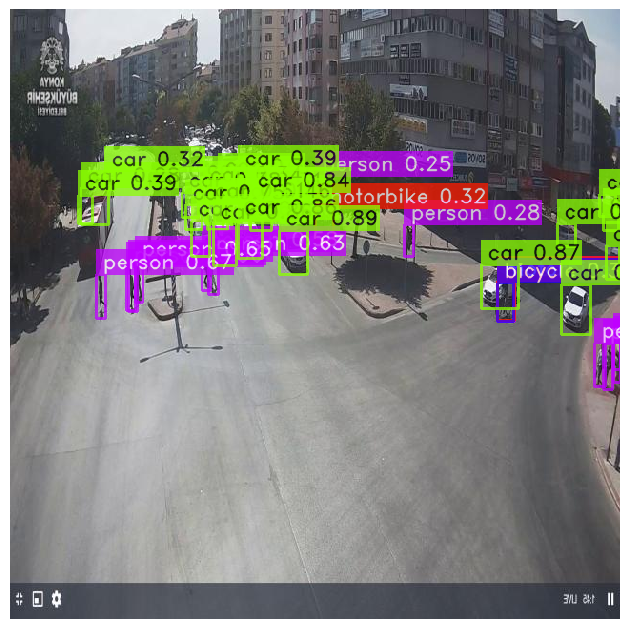

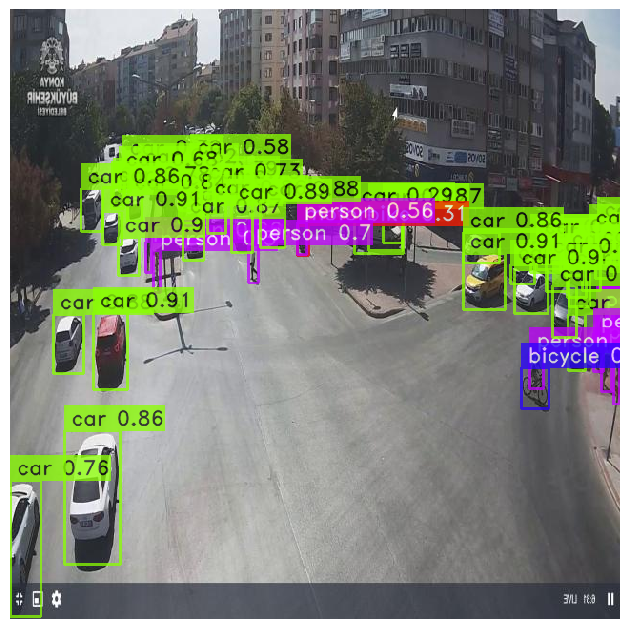

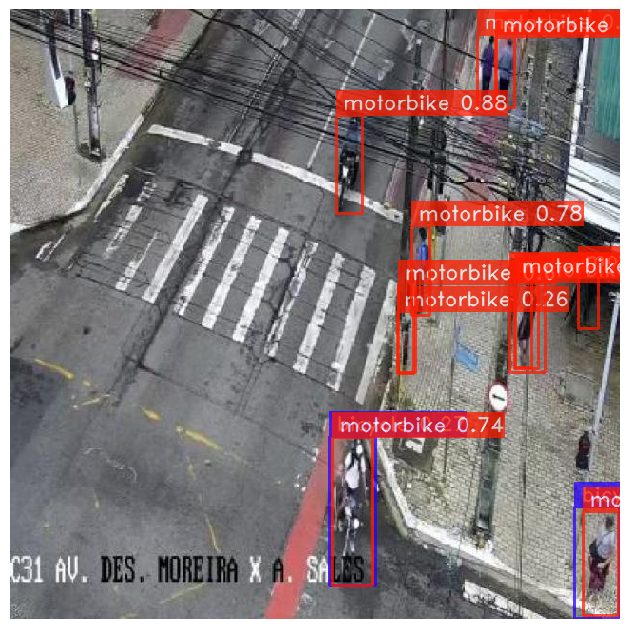

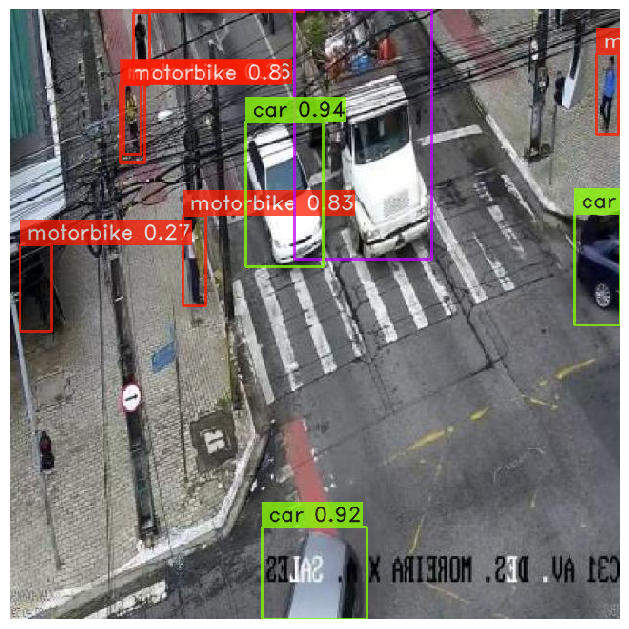

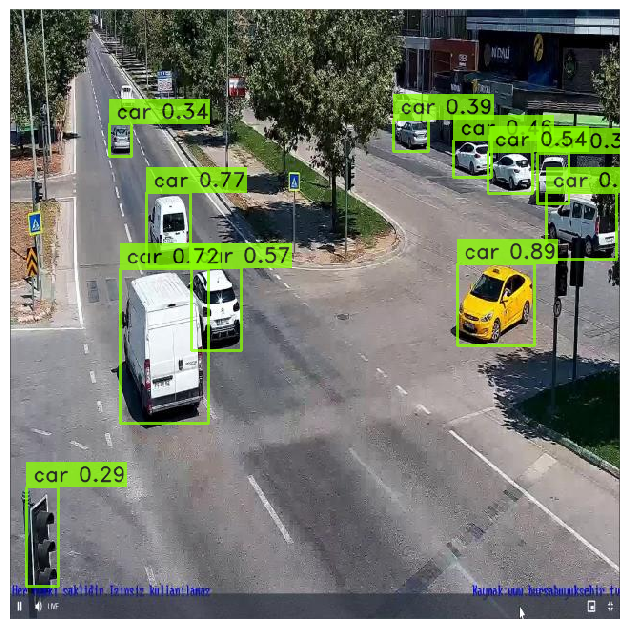

In [13]:
best_model.predict(tpaths2, conf=0.25).show()